In [1]:
__author__ = 'Alysa Obertas'
__email__ = 'obertas@astro.utoronto.ca'

# python systems-predict-stability.py nsys first_sim
#
# predicts stability (for 1e9 orbits) of a 3+ planet system using machine learning
# method developed by Dan Tamayo
#
# finds probability for nsys systems, starting at first_sim
#
# Written by Alysa Obertas (modified from code written by Dan Tamayo)

import numpy as np
import rebound
import matplotlib.pyplot as plt
import matplotlib
import random
import dill
import sys
import pandas as pd
from spock import spockClassifier

try:
    plt.style.use('paper')
except:
    pass

spockoutfile = 'alysa-datafiles/spockprobstesttrio.npz'
megnoprobsoutfile = 'alysa-datafiles/megnoprobstesttrio.npz'
megnosoutfile = 'alysa-datafiles/megnostesttrio.npz'

stride = 20
nsim_list = np.arange(0,17500, stride)

In [2]:
#######################################################################
## read initial condition file

infile_delta_2_to_10 = 'alysa-datafiles/initial_conditions_delta_2_to_10.npz'
infile_delta_10_to_13 = 'alysa-datafiles/initial_conditions_delta_10_to_13.npz'

ic1 = np.load(infile_delta_2_to_10)
ic2 = np.load(infile_delta_10_to_13)

m_star = ic1['m_star'] # mass of star
m_planet = ic1['m_planet'] # mass of planets
rh = (m_planet/3.) ** (1./3.)

Nbody = ic1['Nbody'] # number of planets
year = 2.*np.pi # One year in units where G=1
tf = ic1['tf'] # end time in years

a_init = np.concatenate([ic1['a'], ic2['a']], axis=1) # array containing initial semimajor axis for each delta,planet
f_init = np.concatenate([ic1['f'], ic2['f']], axis=1) # array containing intial longitudinal position for each delta, planet, run

#######################################################################
## create rebound simulation and predict stability for each system in nsim_list

In [3]:
infile_delta_2_to_10 = 'alysa-datafiles/initial_conditions_delta_2_to_10.npz'
infile_delta_10_to_13 = 'alysa-datafiles/initial_conditions_delta_10_to_13.npz'

outfile_nbody_delta_2_to_10 = 'alysa-datafiles/merged_output_files_delta_2_to_10.npz'
outfile_nbody_delta_10_to_13 = 'alysa-datafiles/merged_output_files_delta_10_to_13.npz'

## load hill spacing

ic_delta_2_to_10 = np.load(infile_delta_2_to_10)
ic_delta_10_to_13 = np.load(infile_delta_10_to_13)

delta_2_to_10 = ic_delta_2_to_10['delta']
delta_10_to_13 = ic_delta_10_to_13['delta']

delta = np.hstack((delta_2_to_10, delta_10_to_13))
delta=delta[::stride]

## load rebound simulation first close encounter times

nbody_delta_2_to_10 = np.load(outfile_nbody_delta_2_to_10)
nbody_delta_10_to_13 = np.load(outfile_nbody_delta_10_to_13)

t_exit_delta_2_to_10 = nbody_delta_2_to_10['t_exit']/(0.99)**(3./2)
t_exit_delta_10_to_13 = nbody_delta_10_to_13['t_exit']/(0.99)**(3./2)

t_exit = np.hstack((t_exit_delta_2_to_10, t_exit_delta_10_to_13))
t_exit = t_exit[::stride]

df = pd.DataFrame(np.array([nsim_list, delta, t_exit]).T, columns=['nsim', 'delta', 't_exit'])
df.head()

,nsim,delta,t_exit
0,0.0,2.000573,1.522785
1,20.0,2.015118,9.035188
2,40.0,2.024270,9.695062
3,60.0,2.032864,7.715442
4,80.0,2.041942,1.878101


In [4]:
import sys
sys.path.append('../spock/')
from featurefunctions import spock_features
import os

def init_process():
    global model
    model = spockClassifier()
    
def pred(nsim):
    sim = rebound.Simulation()
    sim.add(m=m_star)
    sim.G = 4*np.pi**2
    for i in range(Nbody): # add the planets
        sim.add(m=m_planet, a=a_init[i,nsim], f=f_init[i,nsim])
    sim.move_to_com()
    sim.integrator="whfast"
    sim.dt = 0.035*sim.particles[1].P
    prob=model.predict(sim)
    return prob

In [5]:
import sys
sys.path.append('../spock/')
from featurefunctions import spock_features
import os

def init_process():
    global model
    model = spockClassifier()
    
def badfeat(nsim):
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=m_star)
    
    for i in range(Nbody): # add the planets
        sim.add(m=m_planet, a=a_init[i,nsim], f=f_init[i,nsim])
    sim.move_to_com()
    sim.integrator="whfast"
    sim.dt = 0.035*sim.particles[1].P
    prob=model.predict(sim)
    t_exit = df[df['nsim']==nsim]['t_exit'].values[0]/sim.particles[1].P
    
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=m_star)

    for i in range(Nbody): # add the planets
        sim.add(m=m_planet, a=a_init[i,nsim], f=f_init[i,nsim])
    sim.move_to_com()
    sim.integrator="whfast"
    sim.dt = 0.035*sim.particles[1].P

    feat = spock_features(sim, (10000, 80, [[1,2,3]]))
    return feat, np.log10(t_exit), prob

In [9]:
model, features, featurefolder = dill.load(open("../models/spockAMDstd.pkl", "rb"))

In [20]:
nsim=17200
sim = rebound.Simulation()
sim.G = 4*np.pi**2
sim.add(m=m_star)

for i in range(Nbody): # add the planets
    sim.add(m=m_planet, a=a_init[i,nsim], f=f_init[i,nsim])
sim.move_to_com()
sim.integrator="whfast"
sim.dt = 0.035*sim.particles[1].P
triofeat = spock_features(sim, (10000, 80, [[1,2,3]]))
feat = triofeat[0]

In [21]:
feat[features]

AMDtriofracnear    0.000814
AMDtriofracfar     0.000881
EPstdnear          0.000102
EPstdfar           0.000092
EMfracstdnear      0.001798
EMfracstdfar       0.001698
MEGNO              2.000298
MEGNOstd           0.222054
EMcrossnear        0.169611
EMcrossfar         0.169611
MMRstrengthnear    0.003297
MMRstrengthfar     0.003134
dtype: float64

In [24]:
f = pd.DataFrame([feat[features]])
f

,AMDtriofracnear,AMDtriofracfar,EPstdnear,EPstdfar,EMfracstdnear,EMfracstdfar,MEGNO,MEGNOstd,EMcrossnear,EMcrossfar,MMRstrengthnear,MMRstrengthfar
0,0.000814,0.000881,0.000102,0.000092,0.001798,0.001698,2.000298,0.222054,0.169611,0.169611,0.003297,0.003134


In [28]:
model.predict_proba(f)[:,1][0]

0.99852496

In [29]:
model = spockClassifier()

In [31]:
feat, logt, prob = badfeat(17200)

[1, 2, 3] 0.9985249638557434 0    0.000814
Name: AMDtriofracnear, dtype: float64
[2, 3, 4] 0.9984164237976074 0    0.000799
Name: AMDtriofracnear, dtype: float64
[3, 4, 5] 0.9989925026893616 0    0.000563
Name: AMDtriofracnear, dtype: float64


In [8]:
print(logt, prob)
print(feat)

5.321047793780246 0.00036604440538212657
[EMfracstdnear               5.845855e-02
EPstdnear                   2.381757e-03
AMDcritnear                 5.007742e-08
AMDtriofracnear             2.544312e-02
EMcrossnear                 1.074365e-01
MMRstrengthnear             4.708441e-02
jnear                       7.000000e+00
knear                       1.000000e+00
EMfracstdfar                7.043593e-02
EPstdfar                    3.057030e-03
AMDcritfar                  5.269888e-08
AMDtriofracfar              2.417748e-02
EMcrossfar                  1.074365e-01
MMRstrengthfar              3.696254e-02
jfar                        7.000000e+00
kfar                        1.000000e+00
MEGNO                       2.568854e+01
MEGNOstd                    8.315806e+00
stableinshortintegration    1.000000e+00
dtype: float64]


In [47]:
from featurefunctions import spock_3p_tseries, spock_init_sim

nsim=9400
trios = [[2,3,4]]
Norbits = 1e4
Nout = 80

sim = rebound.Simulation()
sim.G = 4*np.pi**2
sim.add(m=m_star)

for i in range(Nbody): # add the planets
    sim.add(m=m_planet, a=a_init[i,nsim], f=f_init[i,nsim])
sim.move_to_com()
sim.integrator="whfast"
sim.dt = 0.035*sim.particles[1].P

triopairs, triojks, trioa10s, triotseries = spock_init_sim(sim, trios, Nout)
stable = spock_3p_tseries(sim, Norbits, Nout, trios, triopairs, triojks, trioa10s, triotseries)
tseries = triotseries[0]

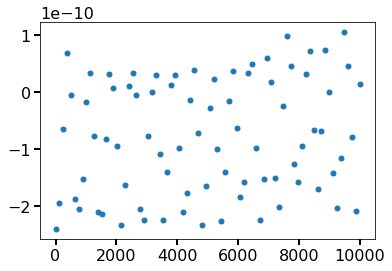

In [48]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(tseries[:,0], tseries[:,7], '.')

In [43]:
tseries[:,1].std()/0.087

0.012232133316763198

In [36]:
nsim=17200
sim = rebound.Simulation()
sim.add(m=m_star)

for i in range(Nbody): # add the planets
    sim.add(m=m_planet, a=a_init[i,nsim], f=f_init[i,nsim])
sim.move_to_com()
sim.integrator="whfast"
sim.dt = 0.035*sim.particles[1].P

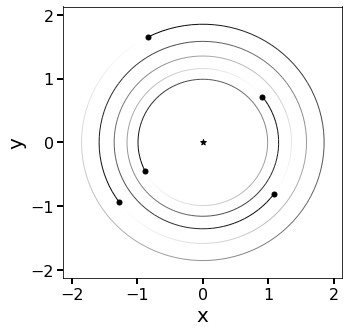

In [38]:
fig = rebound.OrbitPlot(sim)

In [5]:
from multiprocessing import Pool
pool = Pool(processes=24, initializer=init_process)

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r 

In [ ]:
%%time
res = pool.map(pred, nsim_list)

In [ ]:
np.savez(spockoutfile, nsim_list=nsim_list, probs=np.array(res))

In [ ]:
infile_delta_2_to_10 = 'alysa-datafiles/initial_conditions_delta_2_to_10.npz'
infile_delta_10_to_13 = 'alysa-datafiles/initial_conditions_delta_10_to_13.npz'

outfile_nbody_delta_2_to_10 = 'alysa-datafiles/merged_output_files_delta_2_to_10.npz'
outfile_nbody_delta_10_to_13 = 'alysa-datafiles/merged_output_files_delta_10_to_13.npz'

spockoutfile_ml_probs = 'alysa-datafiles/stability-probs-sims-spockalltrios.npz'

## load hill spacing

ic_delta_2_to_10 = np.load(infile_delta_2_to_10)
ic_delta_10_to_13 = np.load(infile_delta_10_to_13)

delta_2_to_10 = ic_delta_2_to_10['delta']
delta_10_to_13 = ic_delta_10_to_13['delta']

delta = np.hstack((delta_2_to_10, delta_10_to_13))
delta=delta[::stride]

## load rebound simulation first close encounter times

nbody_delta_2_to_10 = np.load(outfile_nbody_delta_2_to_10)
nbody_delta_10_to_13 = np.load(outfile_nbody_delta_10_to_13)

t_exit_delta_2_to_10 = nbody_delta_2_to_10['t_exit']/(0.99)**(3./2)
t_exit_delta_10_to_13 = nbody_delta_10_to_13['t_exit']/(0.99)**(3./2)

t_exit = np.hstack((t_exit_delta_2_to_10, t_exit_delta_10_to_13))
t_exit = t_exit[::stride]

log_t_exit = np.log10(t_exit)
survival_1e9 = log_t_exit >= 9

survival_true = survival_1e9 == True
survival_false = survival_1e9 == False

## load machine learning stability probabilities

spockml_data = np.load(spockoutfile)
spockprobs = spockml_data['probs']

delta.shape

#  TPR

In [9]:
thresh = 0.49
(spockprobs[survival_true] > thresh).sum()/survival_true.sum()

0.0

# FPR

In [10]:
(spockprobs[survival_false] > thresh).sum()/survival_false.sum()

0.0

In [11]:
survival_false.sum()

766

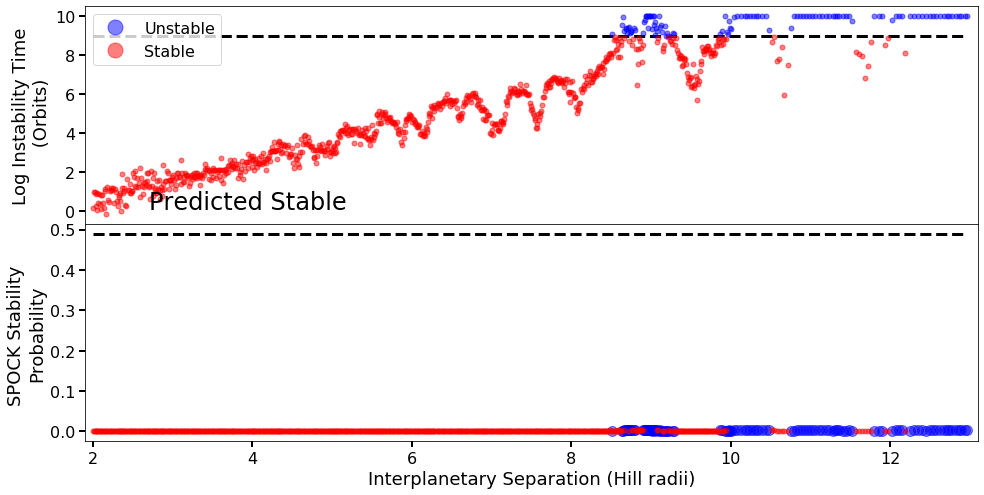

In [12]:
## plot delta vs prob

fig, ax = plt.subplots(2, 1, figsize=(16,8), sharex=True)
plt.subplots_adjust(hspace=0, wspace=0)

# scatter

ms=5

ax[0].plot([np.min(delta), np.max(delta)], [9,9], '--k')
ax[0].plot(delta[survival_true],log_t_exit[survival_true],'ob', alpha=0.5, markersize=ms,rasterized=True,label='Unstable')
ax[0].plot(delta[survival_false],log_t_exit[survival_false],'or', alpha=0.5, markersize=ms,rasterized=True,label='Stable')

ax[1].plot([np.min(delta), np.max(delta)], [0.49,0.49], '--k')
ax[1].plot(delta[survival_true], spockprobs[survival_true],'ob', alpha=0.5, markersize=ms*2,rasterized=True)
ax[1].plot(delta[survival_false], spockprobs[survival_false],'or', alpha=0.5, markersize=ms, rasterized=True)

ax[1].annotate("", xy=(2.5, 0.7), xytext=(2.5, 0.52), arrowprops=dict(facecolor='black'))
ax[1].text(2.7, 0.55, "Predicted Stable", fontsize=24)

ax[1].set_xlabel("Interplanetary Separation (Hill radii)", fontsize=18)
ax[1].set_xlim([1.9, 13.1])

ax[1].set_ylabel("SPOCK Stability \nProbability", fontsize=18)
ax[0].set_ylabel("Log Instability Time\n (Orbits)", fontsize=18)

ax[0].legend(loc=2, markerscale=3)
plt.savefig('alysa.pdf',bbox_inches='tight')

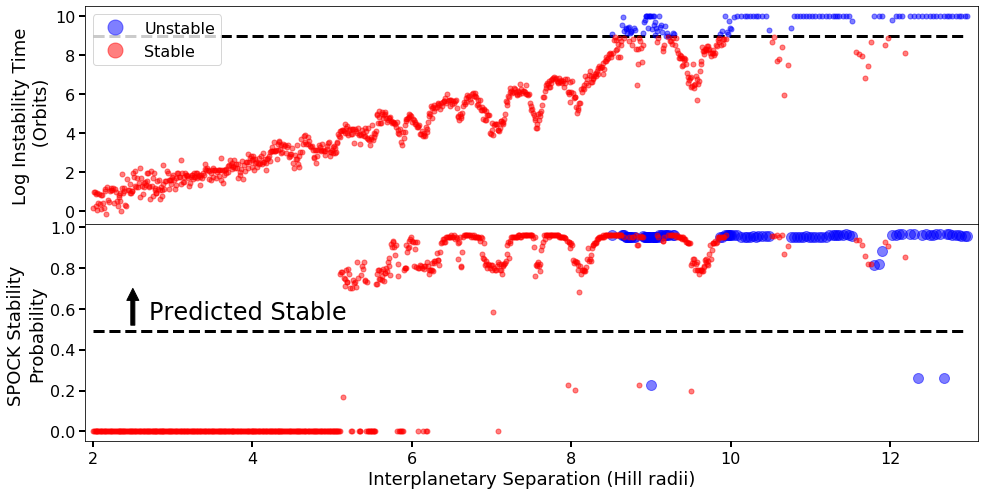

In [9]:
## plot delta vs prob

fig, ax = plt.subplots(2, 1, figsize=(16,8), sharex=True)
plt.subplots_adjust(hspace=0, wspace=0)

# scatter

ms=5

ax[0].plot([np.min(delta), np.max(delta)], [9,9], '--k')
ax[0].plot(delta[survival_true],log_t_exit[survival_true],'ob', alpha=0.5, markersize=ms,rasterized=True,label='Unstable')
ax[0].plot(delta[survival_false],log_t_exit[survival_false],'or', alpha=0.5, markersize=ms,rasterized=True,label='Stable')

ax[1].plot([np.min(delta), np.max(delta)], [0.49,0.49], '--k')
ax[1].plot(delta[survival_true], spockprobs[survival_true],'ob', alpha=0.5, markersize=ms*2,rasterized=True)
ax[1].plot(delta[survival_false], spockprobs[survival_false],'or', alpha=0.5, markersize=ms, rasterized=True)

ax[1].annotate("", xy=(2.5, 0.7), xytext=(2.5, 0.52), arrowprops=dict(facecolor='black'))
ax[1].text(2.7, 0.55, "Predicted Stable", fontsize=24)

ax[1].set_xlabel("Interplanetary Separation (Hill radii)", fontsize=18)
ax[1].set_xlim([1.9, 13.1])

ax[1].set_ylabel("SPOCK Stability \nProbability", fontsize=18)
ax[0].set_ylabel("Log Instability Time\n (Orbits)", fontsize=18)

ax[0].legend(loc=2, markerscale=3)
plt.savefig('alysa.pdf',bbox_inches='tight')

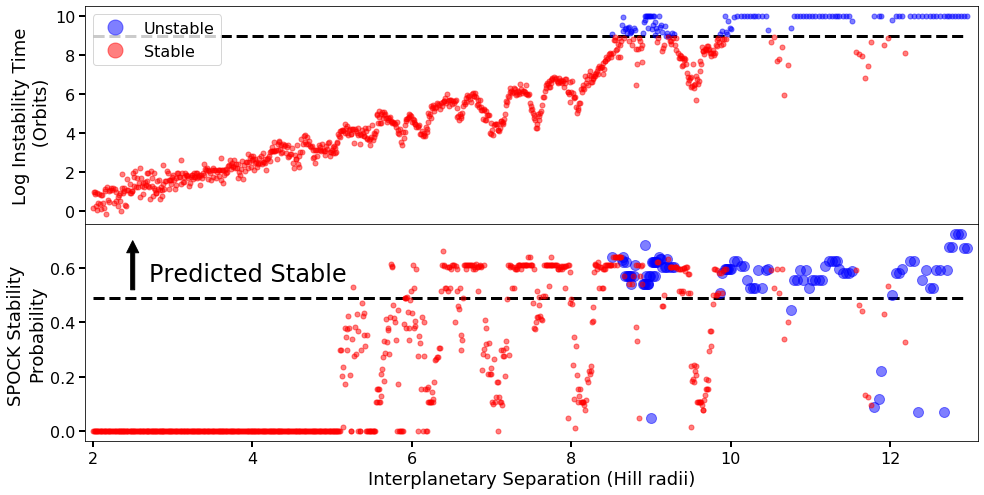

In [9]:
## plot delta vs prob

fig, ax = plt.subplots(2, 1, figsize=(16,8), sharex=True)
plt.subplots_adjust(hspace=0, wspace=0)

# scatter

ms=5

ax[0].plot([np.min(delta), np.max(delta)], [9,9], '--k')
ax[0].plot(delta[survival_true],log_t_exit[survival_true],'ob', alpha=0.5, markersize=ms,rasterized=True,label='Unstable')
ax[0].plot(delta[survival_false],log_t_exit[survival_false],'or', alpha=0.5, markersize=ms,rasterized=True,label='Stable')

ax[1].plot([np.min(delta), np.max(delta)], [0.49,0.49], '--k')
ax[1].plot(delta[survival_true], spockprobs[survival_true],'ob', alpha=0.5, markersize=ms*2,rasterized=True)
ax[1].plot(delta[survival_false], spockprobs[survival_false],'or', alpha=0.5, markersize=ms, rasterized=True)

ax[1].annotate("", xy=(2.5, 0.7), xytext=(2.5, 0.52), arrowprops=dict(facecolor='black'))
ax[1].text(2.7, 0.55, "Predicted Stable", fontsize=24)

ax[1].set_xlabel("Interplanetary Separation (Hill radii)", fontsize=18)
ax[1].set_xlim([1.9, 13.1])

ax[1].set_ylabel("SPOCK Stability \nProbability", fontsize=18)
ax[0].set_ylabel("Log Instability Time\n (Orbits)", fontsize=18)

ax[0].legend(loc=2, markerscale=3)
plt.savefig('alysa.pdf',bbox_inches='tight')

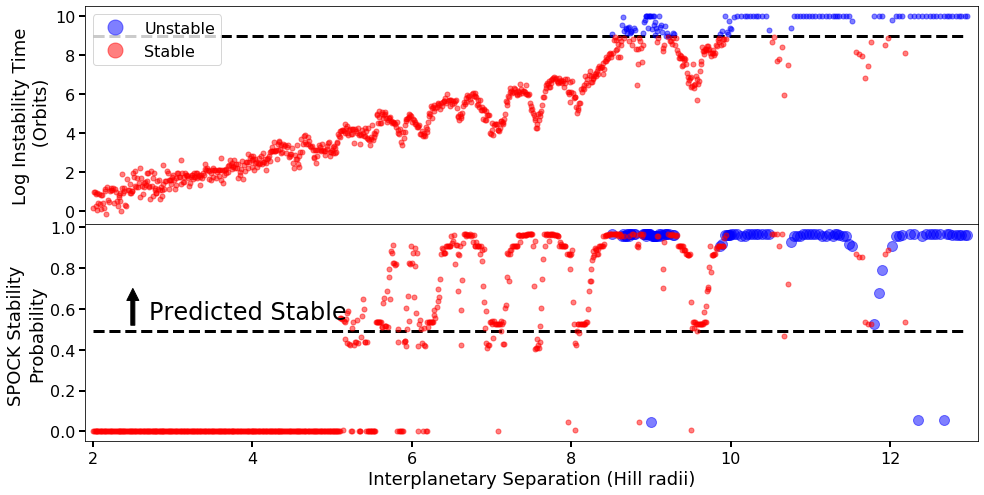

In [9]:
## plot delta vs prob

fig, ax = plt.subplots(2, 1, figsize=(16,8), sharex=True)
plt.subplots_adjust(hspace=0, wspace=0)

# scatter

ms=5

ax[0].plot([np.min(delta), np.max(delta)], [9,9], '--k')
ax[0].plot(delta[survival_true],log_t_exit[survival_true],'ob', alpha=0.5, markersize=ms,rasterized=True,label='Unstable')
ax[0].plot(delta[survival_false],log_t_exit[survival_false],'or', alpha=0.5, markersize=ms,rasterized=True,label='Stable')

ax[1].plot([np.min(delta), np.max(delta)], [0.49,0.49], '--k')
ax[1].plot(delta[survival_true], spockprobs[survival_true],'ob', alpha=0.5, markersize=ms*2,rasterized=True)
ax[1].plot(delta[survival_false], spockprobs[survival_false],'or', alpha=0.5, markersize=ms, rasterized=True)

ax[1].annotate("", xy=(2.5, 0.7), xytext=(2.5, 0.52), arrowprops=dict(facecolor='black'))
ax[1].text(2.7, 0.55, "Predicted Stable", fontsize=24)

ax[1].set_xlabel("Interplanetary Separation (Hill radii)", fontsize=18)
ax[1].set_xlim([1.9, 13.1])

ax[1].set_ylabel("SPOCK Stability \nProbability", fontsize=18)
ax[0].set_ylabel("Log Instability Time\n (Orbits)", fontsize=18)

ax[0].legend(loc=2, markerscale=3)
plt.savefig('alysa.pdf',bbox_inches='tight')

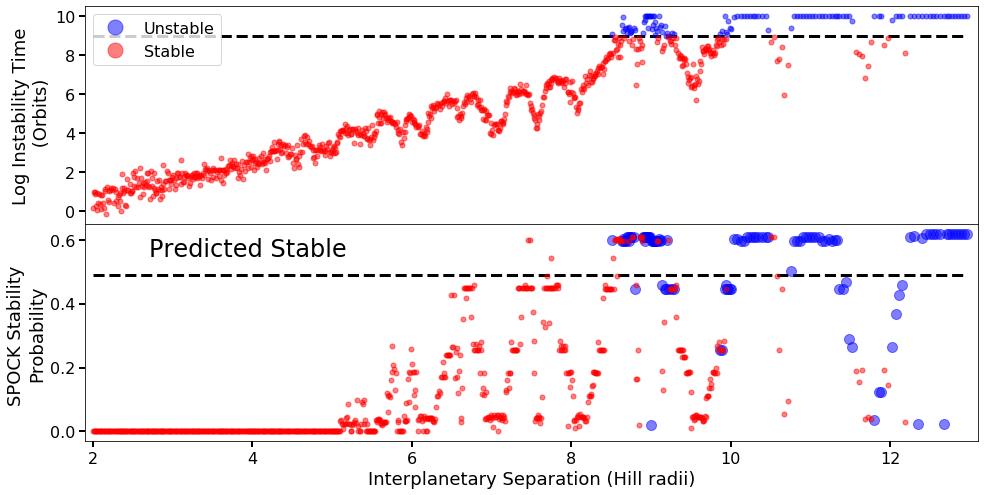

In [14]:
## plot delta vs prob

fig, ax = plt.subplots(2, 1, figsize=(16,8), sharex=True)
plt.subplots_adjust(hspace=0, wspace=0)

# scatter

ms=5

ax[0].plot([np.min(delta), np.max(delta)], [9,9], '--k')
ax[0].plot(delta[survival_true],log_t_exit[survival_true],'ob', alpha=0.5, markersize=ms,rasterized=True,label='Unstable')
ax[0].plot(delta[survival_false],log_t_exit[survival_false],'or', alpha=0.5, markersize=ms,rasterized=True,label='Stable')

ax[1].plot([np.min(delta), np.max(delta)], [0.49,0.49], '--k')
ax[1].plot(delta[survival_true], spockprobs[survival_true],'ob', alpha=0.5, markersize=ms*2,rasterized=True)
ax[1].plot(delta[survival_false], spockprobs[survival_false],'or', alpha=0.5, markersize=ms, rasterized=True)

ax[1].annotate("", xy=(2.5, 0.7), xytext=(2.5, 0.52), arrowprops=dict(facecolor='black'))
ax[1].text(2.7, 0.55, "Predicted Stable", fontsize=24)

ax[1].set_xlabel("Interplanetary Separation (Hill radii)", fontsize=18)
ax[1].set_xlim([1.9, 13.1])

ax[1].set_ylabel("SPOCK Stability \nProbability", fontsize=18)
ax[0].set_ylabel("Log Instability Time\n (Orbits)", fontsize=18)

ax[0].legend(loc=2, markerscale=3)
plt.savefig('alysa.pdf',bbox_inches='tight')

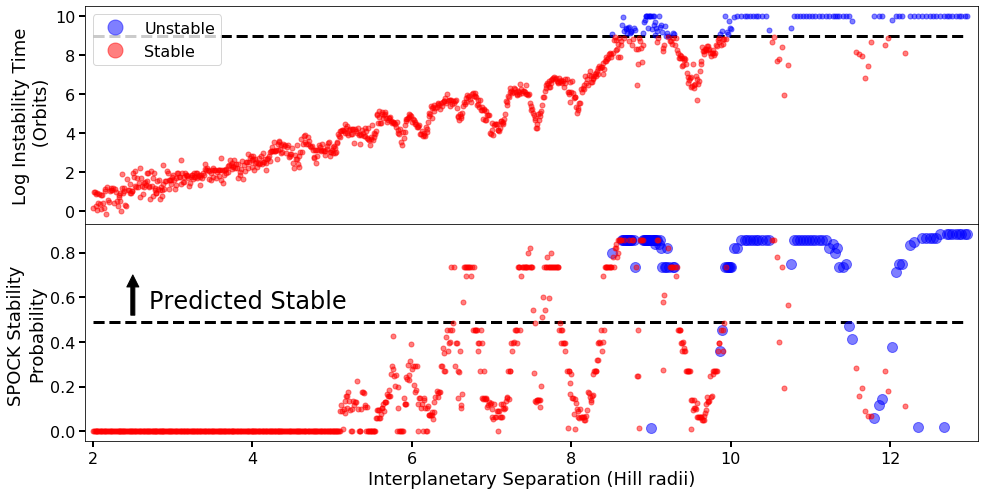

In [12]:
## plot delta vs prob

fig, ax = plt.subplots(2, 1, figsize=(16,8), sharex=True)
plt.subplots_adjust(hspace=0, wspace=0)a

# scatter

ms=5

ax[0].plot([np.min(delta), np.max(delta)], [9,9], '--k')
ax[0].plot(delta[survival_true],log_t_exit[survival_true],'ob', alpha=0.5, markersize=ms,rasterized=True,label='Unstable')
ax[0].plot(delta[survival_false],log_t_exit[survival_false],'or', alpha=0.5, markersize=ms,rasterized=True,label='Stable')

ax[1].plot([np.min(delta), np.max(delta)], [0.49,0.49], '--k')
ax[1].plot(delta[survival_true], spockprobs[survival_true],'ob', alpha=0.5, markersize=ms*2,rasterized=True)
ax[1].plot(delta[survival_false], spockprobs[survival_false],'or', alpha=0.5, markersize=ms, rasterized=True)

ax[1].annotate("", xy=(2.5, 0.7), xytext=(2.5, 0.52), arrowprops=dict(facecolor='black'))
ax[1].text(2.7, 0.55, "Predicted Stable", fontsize=24)

ax[1].set_xlabel("Interplanetary Separation (Hill radii)", fontsize=18)
ax[1].set_xlim([1.9, 13.1])

ax[1].set_ylabel("SPOCK Stability \nProbability", fontsize=18)
ax[0].set_ylabel("Log Instability Time\n (Orbits)", fontsize=18)

ax[0].legend(loc=2, markerscale=3)
plt.savefig('alysa.pdf',bbox_inches='tight')

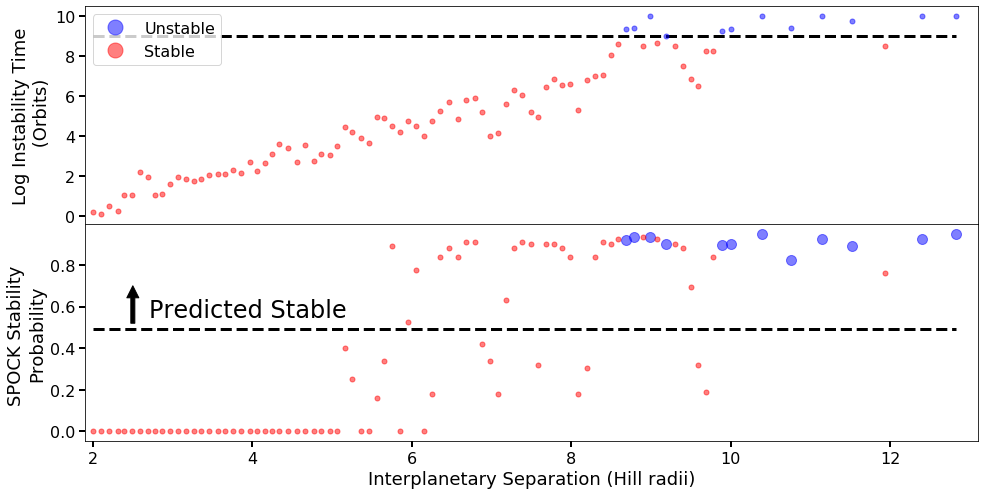

In [12]:
## plot delta vs prob

fig, ax = plt.subplots(2, 1, figsize=(16,8), sharex=True)
plt.subplots_adjust(hspace=0, wspace=0)

# scatter

ms=5

ax[0].plot([np.min(delta), np.max(delta)], [9,9], '--k')
ax[0].plot(delta[survival_true],log_t_exit[survival_true],'ob', alpha=0.5, markersize=ms,rasterized=True,label='Unstable')
ax[0].plot(delta[survival_false],log_t_exit[survival_false],'or', alpha=0.5, markersize=ms,rasterized=True,label='Stable')

ax[1].plot([np.min(delta), np.max(delta)], [0.49,0.49], '--k')
ax[1].plot(delta[survival_true], spockprobs[survival_true],'ob', alpha=0.5, markersize=ms*2,rasterized=True)
ax[1].plot(delta[survival_false], spockprobs[survival_false],'or', alpha=0.5, markersize=ms, rasterized=True)

ax[1].annotate("", xy=(2.5, 0.7), xytext=(2.5, 0.52), arrowprops=dict(facecolor='black'))
ax[1].text(2.7, 0.55, "Predicted Stable", fontsize=24)

ax[1].set_xlabel("Interplanetary Separation (Hill radii)", fontsize=18)
ax[1].set_xlim([1.9, 13.1])

ax[1].set_ylabel("SPOCK Stability \nProbability", fontsize=18)
ax[0].set_ylabel("Log Instability Time\n (Orbits)", fontsize=18)

ax[0].legend(loc=2, markerscale=3)
plt.savefig('alysa.pdf',bbox_inches='tight')